## Group Level Analysis

In [1]:
import os
os.chdir("/Users/giuseppe/Documents/Projects/RL_sim/")
from agents.utils import create_bins, discretize_observation
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import numpy as np
import pandas as pd
import json
import ast

def read_json_log(log):
    with open(log, "rb") as f:
        log = json.load(f)
    return log
    
def json_array_to_list(arr):
    return ast.literal_eval(arr)


def score_datapoints(arr):
    mu = np.mean(arr)
    sigma = np.std(arr)
    return np.abs(arr - mu) < sigma

def calculate_snr(log):
    if isinstance(log, str):
        log = read_json_log(log)
    reward = np.array(json_array_to_list(log[-1]["reward"]))
    return reward.mean() / reward.std()

def plot_reward(log):
    log = read_json_log(log)
    reward = json_array_to_list(log[-1]["reward"])
    size = range(len(reward))
    snr = np.float16(calculate_snr(log))
    df = pd.DataFrame(columns=["trial", "reward"])
    df["trial"] = size
    df["reward"] = reward

    df = df[score_datapoints(df["reward"])]
    plt.figure(figsize=(10, 4))
    sns.regplot(x="trial", y="reward", data=df)
    plt.xlabel("Trials", fontsize=16)
    plt.ylabel("Reward", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title(f"SNR: {snr}, Kernel Sigma: 4.0", fontsize=20)
    plt.show()

def get_q_table_max(log, table_size):
    maxima = []
    for table in log:
        q_table = json_array_to_list(table["q_table"])
        maxima.append(np.unravel_index(np.argmax(q_table), table_size))
    return maxima

def get_q_table_steps(log, num_bins):
    steps = []
    for data in log:
        contrast = data["contrast"]
        frequency = data["frequency"]
        bins = create_bins(num_bins)
        steps.append(discretize_observation([contrast, frequency], bins))
    return steps

def plot_q_table_steps(log, session):
    log = read_json_log(log)
    last_table = np.array(json_array_to_list(log[-1]["q_table"])).reshape(10, 10)
    maxima = np.array(get_q_table_steps(log, 10)) + 1 # adjust discretization;
    steps = np.random.randint(0, len(maxima), len(maxima))

    plt.imshow(last_table)
    plt.xlabel("Frequency", fontsize=16)
    plt.ylabel("Contrast", fontsize=16)
    plt.colorbar().set_label("Q-value", fontsize=16)
    plt.plot(maxima[:, 1], maxima[:, 0], "--", alpha=0.4)
    plt.scatter(maxima[:, 1], maxima[:, 0], c=steps, cmap='plasma', alpha=0.5)
    plt.colorbar().set_label("Trial number", fontsize=16)
    plt.title(f"Real-time fMRI - Session {session}", fontsize=20)
    plt.show()


### Plot mean reward (all runs)

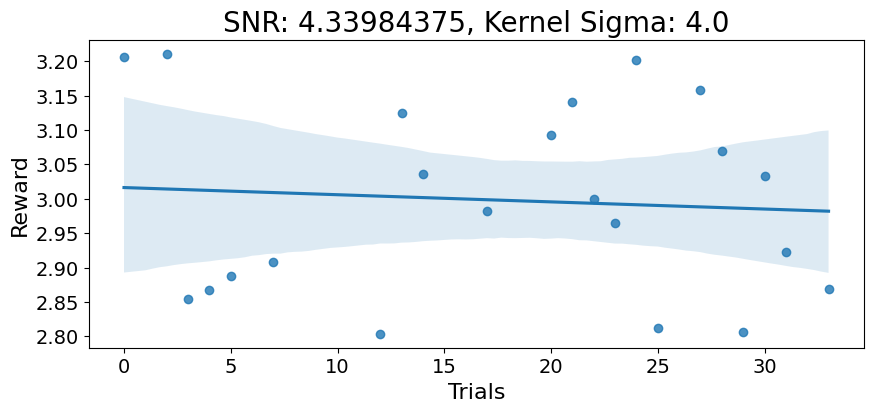

In [6]:
def pad_to_max_length(arr, max_length):
    return np.pad(arr, (0, max_length - len(arr)), mode='constant', constant_values=0)

def plot_reward(logs):
    reward_log = []
    SNRs = []
    sizes = []

    for log in logs:
        log = read_json_log(log)
        reward = json_array_to_list(log[-1]["reward"])
        sizes.append(len(reward))

    max_length = np.max(sizes)
    min_length = np.min(sizes)

    for log in logs:
        log = read_json_log(log)
        reward = json_array_to_list(log[-1]["reward"])
        SNRs.append(np.float16(calculate_snr(log)))
        
        if len(reward_log) == 0:
            reward_log = pad_to_max_length(reward, max_length)
        else:
            reward_log = np.vstack((reward_log, pad_to_max_length(reward, max_length)))

    
    snr = np.mean(SNRs)
    df = pd.DataFrame(columns=["trial", "reward"])
    df["trial"] = np.arange(min_length)
    df["reward"] = np.mean(reward_log[:, :min_length], axis=0)

    df = df[score_datapoints(df["reward"])]
    plt.figure(figsize=(10, 4))
    sns.regplot(x="trial", y="reward", data=df)
    plt.xlabel("Trials", fontsize=16)
    plt.ylabel("Reward", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title(f"SNR: {snr}, Kernel Sigma: 4.0", fontsize=20)
    plt.show()


subjects = ["sub-001", "sub-002", "sub-003"]
datapoints = ["data_1", "data_2"]
logs = [f"/Users/giuseppe/Documents/Projects/RL_sim/data/{sub}/{data}/log/log.json" for sub in subjects for data in datapoints]

plot_reward(logs)

### Plot mean Convergence

### Plot mean Q-table

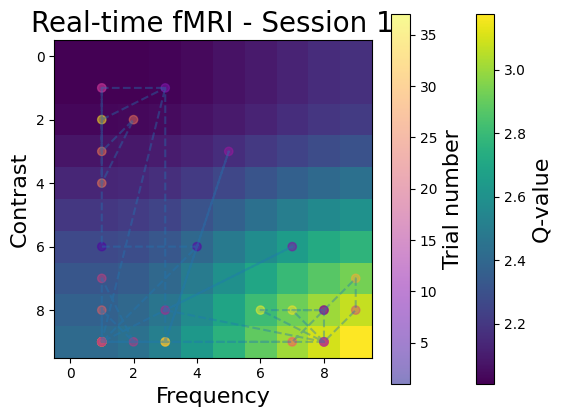

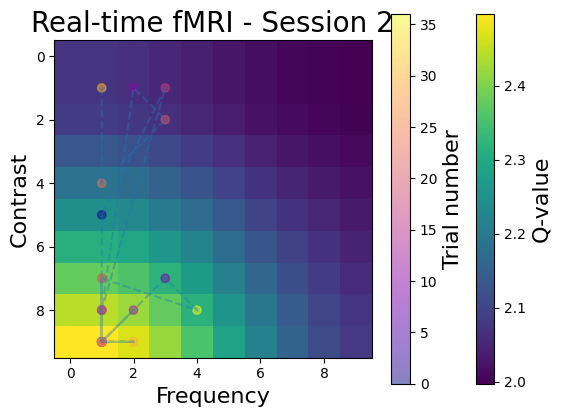

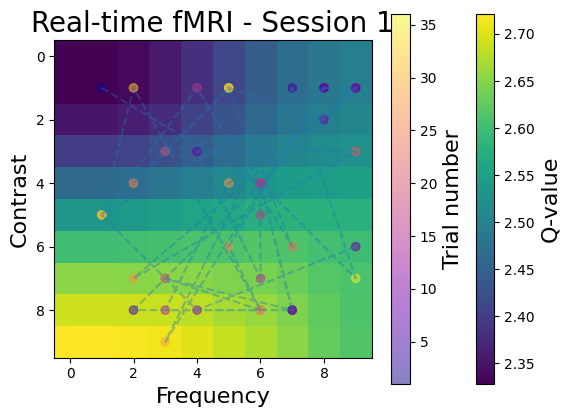

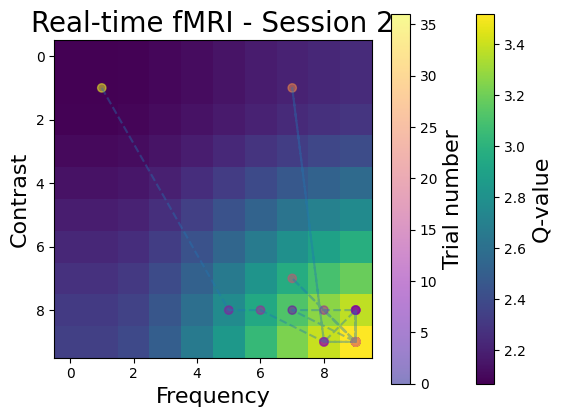

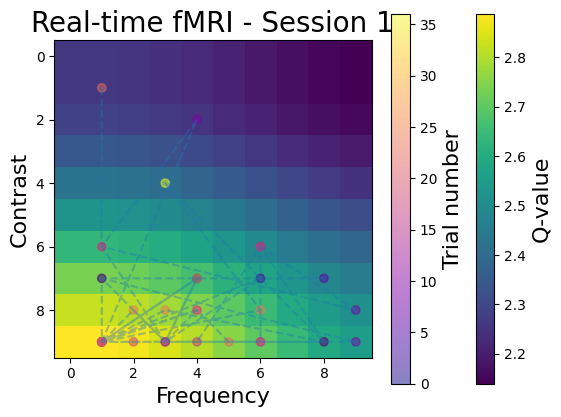

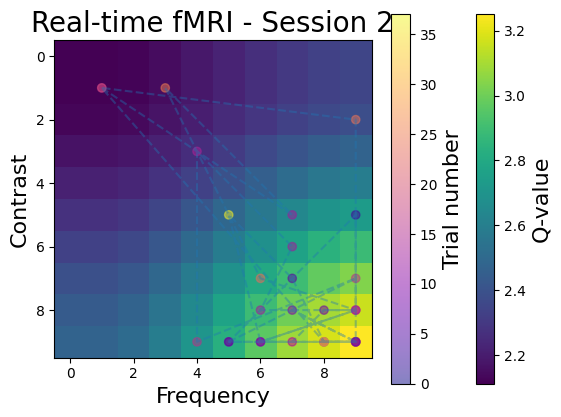

In [15]:
for sub in ["sub-001", "sub-002", "sub-003"]:
    logs = [
        f"/Users/giuseppe/Documents/Projects/RL_sim/data/{sub}/data_1/log/log.json",
        f"/Users/giuseppe/Documents/Projects/RL_sim/data/{sub}/data_2/log/log.json"
    ]

    for idx, log in enumerate(logs):
        plot_q_table_steps(log, idx + 1)

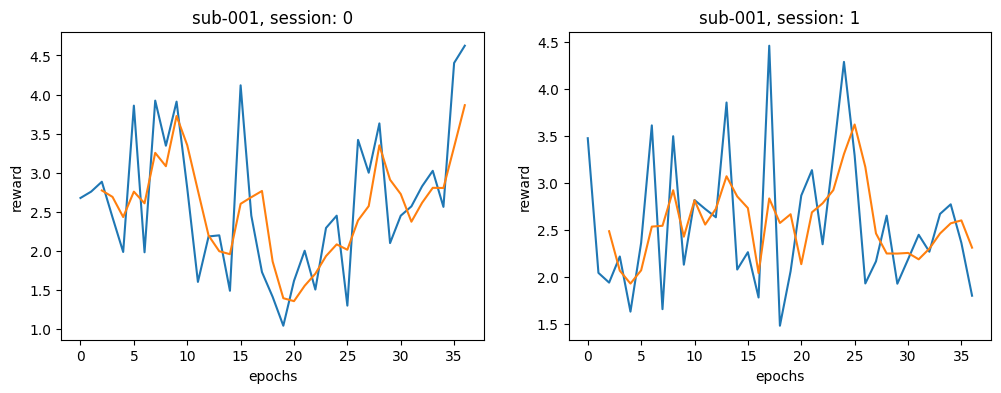

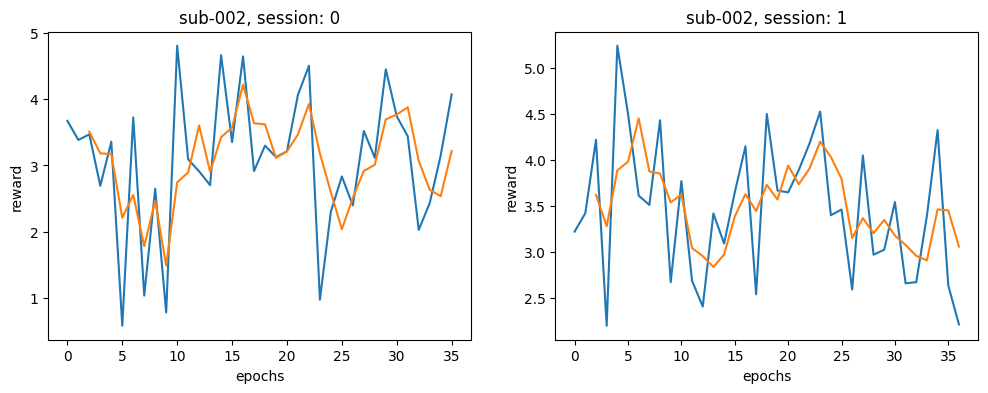

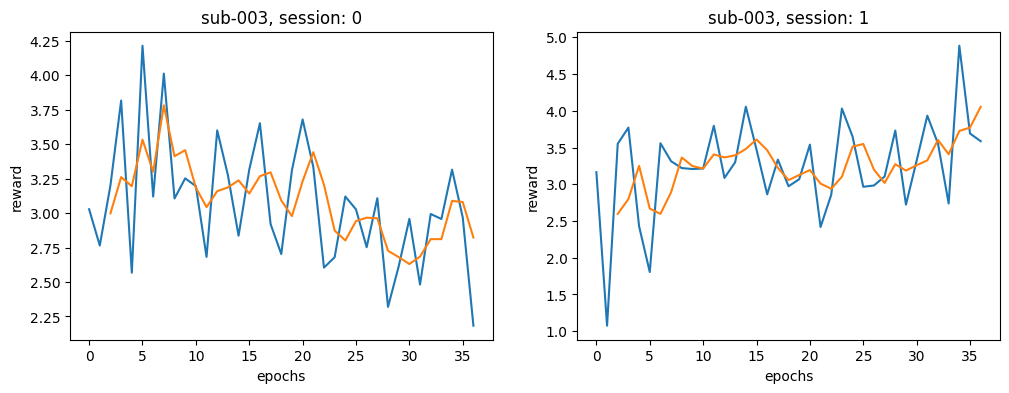

In [16]:
for sub in ["sub-001", "sub-002", "sub-003"]:
    logs = [
        f"/Users/giuseppe/Documents/Projects/RL_sim/data/{sub}/data_1/log/log.json",
        f"/Users/giuseppe/Documents/Projects/RL_sim/data/{sub}/data_2/log/log.json"
    ]

    n_plot = 0
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    for log in logs:

        log = read_json_log(log)
        reward = json_array_to_list(log[-1]["reward"])
        rolling_mean = pd.Series(reward).rolling(window=3).mean()

        # plot reward;
        axs[n_plot].set_title(f"{sub}, session: {n_plot}")
        axs[n_plot].plot(reward)
        axs[n_plot].plot(rolling_mean.to_numpy())
        axs[n_plot].set_xlabel("epochs")
        axs[n_plot].set_ylabel("reward")
        n_plot += 1

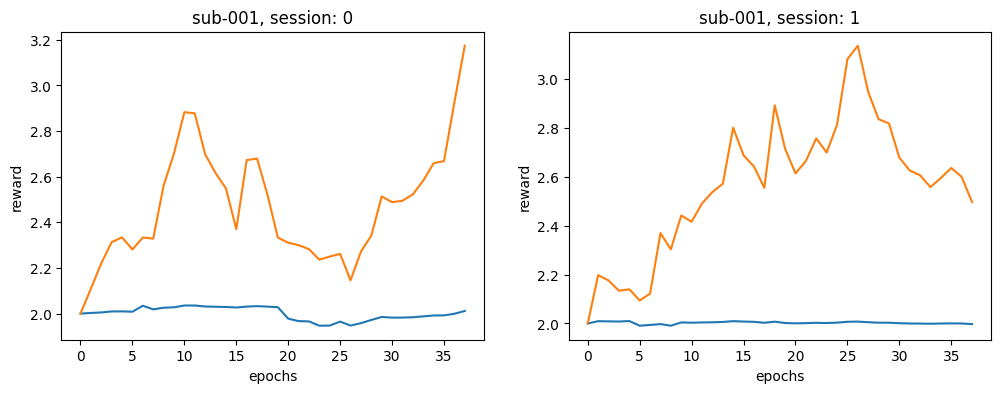

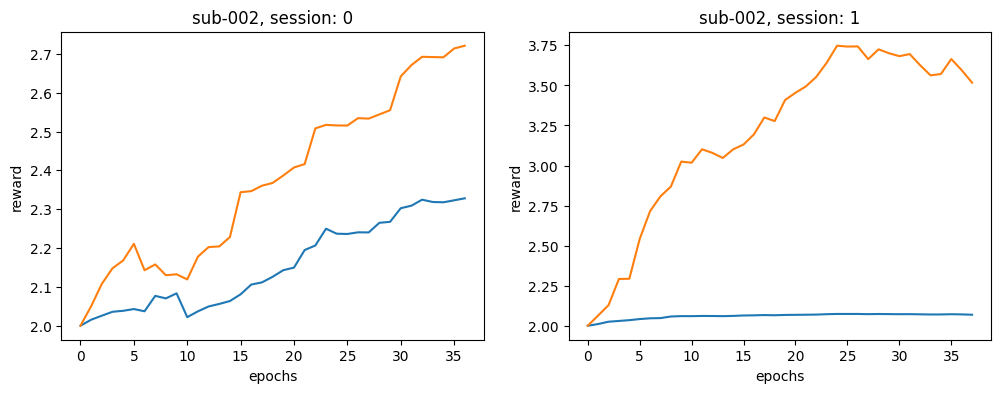

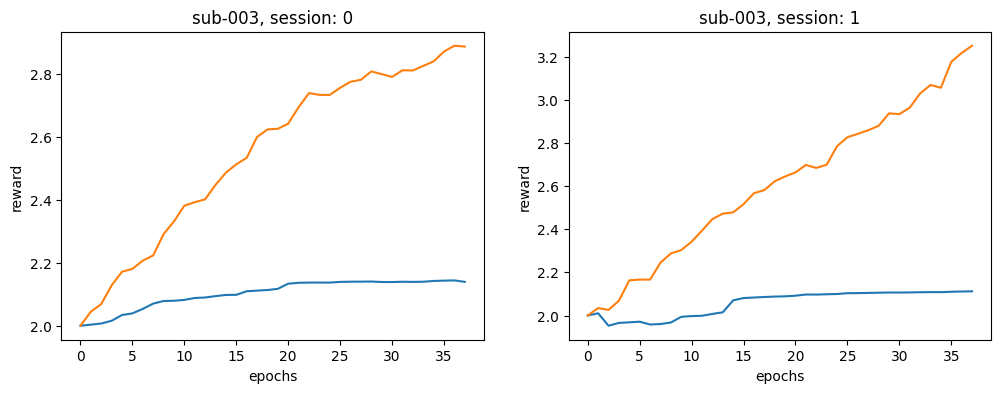

In [17]:
for sub in ["sub-001", "sub-002", "sub-003"]:
    logs = [
        f"/Users/giuseppe/Documents/Projects/RL_sim/data/{sub}/data_1/log/log.json",
        f"/Users/giuseppe/Documents/Projects/RL_sim/data/{sub}/data_2/log/log.json"
    ]

    n_plot = 0
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    for log in logs:
        log = read_json_log(log)
        max_val = []
        min_val = []

        for idx in range(len(log)):
            table = np.array(json_array_to_list(log[idx]["q_table"]))
            min_val.append(np.min(table))
            max_val.append(np.max(table))


        # plot reward;
        axs[n_plot].set_title(f"{sub}, session: {n_plot}")
        axs[n_plot].plot(min_val)
        axs[n_plot].plot(max_val)
        axs[n_plot].set_xlabel("epochs")
        axs[n_plot].set_ylabel("reward")
        n_plot += 1

In [52]:
log = read_json_log("/home/giuseppe/PNI/Bkup/Projects/RL_sim/data/sub-001/data_1/log/log.json")
contrast = []
frequency = []
reward_log = []

for idx in range(len(log)):
    contrast.append(json_array_to_list(log[idx]["last action"])[0])
    frequency.append(json_array_to_list(log[idx]["last action"])[1])

reward = json_array_to_list(log[-1]["reward"])
reward.insert(0, 0)

data = pd.DataFrame({
    'Contrast': contrast,
    'Frequency': frequency,
    'Reward': reward
})

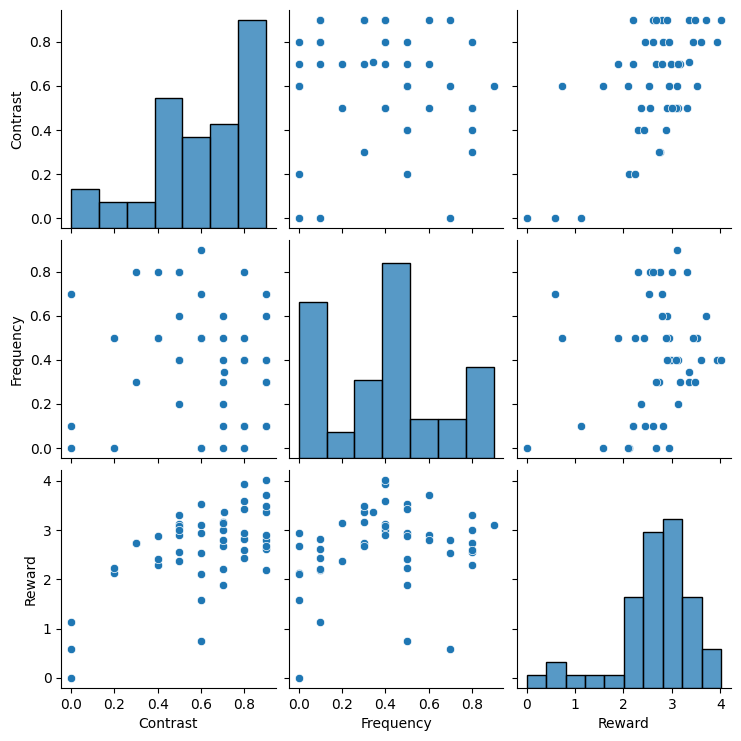

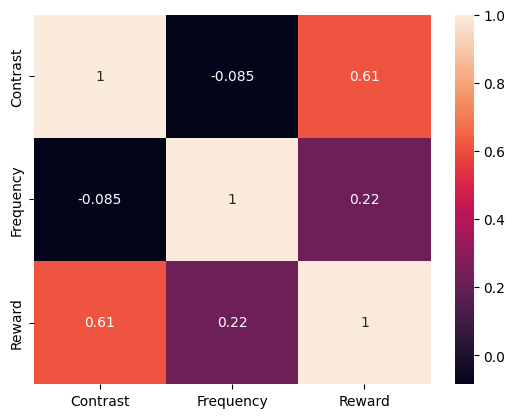

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pairplot to visualize relationships
sns.pairplot(data)
plt.show()

# Correlation matrix
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()